In this notebook, you should implement a first version of a working machine learning model to predict the age of an Abalone.

A few guidelines:
- The model does not have to be complex. A simple linear regression model is enough.
- You should use MLflow to track your experiments. You can use the MLflow UI to compare your experiments.
- Do not push any MLflow data to the repository. Only the code to run the experiments is interesting and should be pushed.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression

In [2]:
# Chargement des données
df = pd.read_csv("../data/abalone.csv")
df.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Préparation des données
# Création d'une nouvelle variable "Age" si nécessaire
df["Age"] = df["Rings"] + 1.5

# Définition des features (X) et de la cible (y)
X = df.drop(columns=["Rings", "Age"])  # toutes les colonnes sauf la cible
y = df["Rings"]


In [4]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (3341, 8)
Test shape: (836, 8)


In [5]:
# Prétraitement
# Colonnes catégorielles et numériques
categorical = ["Sex"]
numerical = ["Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight"]

# Pipeline de prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical),
        ("num", StandardScaler(), numerical)
    ]
)

In [6]:
# Modèle baseline : Régression linéaire
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Entraînement
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Sex']),
                                                 ('num', StandardScaler(),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight'])])),
                ('regressor', LinearRegression())])

In [7]:
# Évaluation du modèle
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")

MAE  : 1.593
RMSE : 2.212
R²   : 0.548


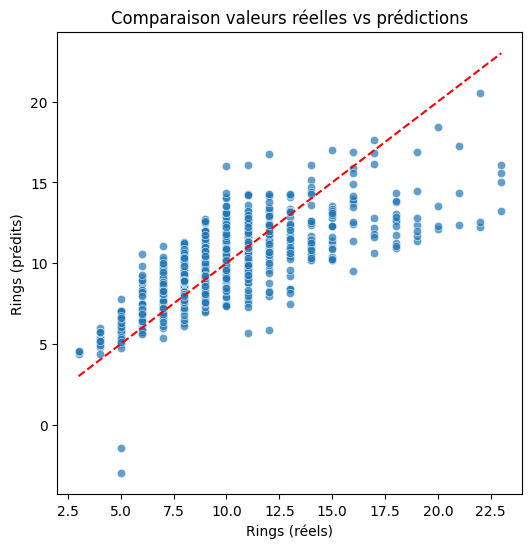

In [8]:
# Visualisation des performances
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("Rings (réels)")
plt.ylabel("Rings (prédits)")
plt.title("Comparaison valeurs réelles vs prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

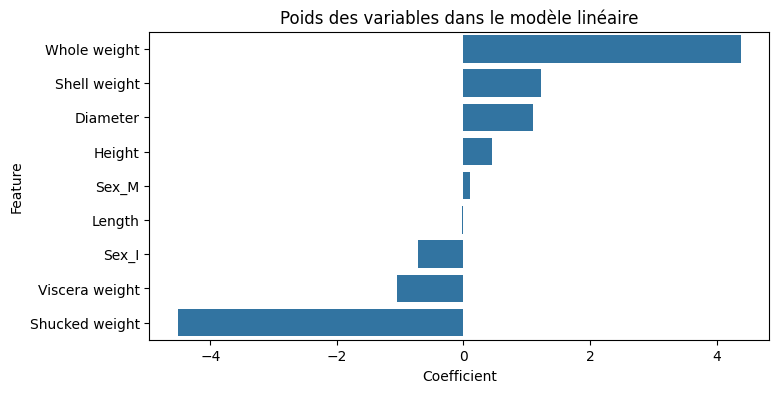

In [9]:
# Importance des features (optionnel, pour modèle linéaire)
# Récupération des coefficients
encoder = model.named_steps["preprocessor"].named_transformers_["cat"]
encoded_features = encoder.get_feature_names_out(categorical)
feature_names = np.concatenate([encoded_features, numerical])
coefficients = model.named_steps["regressor"].coef_

feat_importance = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
feat_importance.sort_values(by="Coefficient", ascending=False, inplace=True)

plt.figure(figsize=(8,4))
sns.barplot(data=feat_importance, x="Coefficient", y="Feature")
plt.title("Poids des variables dans le modèle linéaire")
plt.show()